# Searching Clinvar, GDC, Cosmic

## Clinvar: accessed through Entrez and Eutilities

 Given your amino acid changes, specify the fields using your HGVS format change:
- For arginine 117 to Histidine, you'd write your change as p.Arg117His; alternatively, could also do p.R117H.
- Sample: CFTR[Gene] AND p.R117H


***Looking for how to specifically have this in amino acid -> amino acid format***


## Regex the Amino Acids

May be able to just pull single variant nucleotides

In [1]:
import pandas as pd
import time

In [2]:
#Find Amino Acid Changes
def find_muts(df, cols):
    mutations = set()
    for col in cols:
        lsts = list(map(str, (df[col])))
        mutations.update((set([mut for lst in lsts for mut in lst.split(";")])))
    mut_list = list(mutations)
    #Clean up
    mut_list.remove("nan")
    mut_list.remove("")
    
    return mut_list

In [3]:
def split_into_batches(lst, batch_size):
    for i in range(0, len(lst), batch_size):
        yield lst[i:i + batch_size]

def process_mutation(mut):
    if "AND" in mut:
        return "(" + mut + ")"
    else:
        return mut

def build_query(mut_list, gene):
    #Builds a clinvar query, splitting query into batches of 1000.
    #if contains "/", replace with AND, changing . to *, adding p. for query purposes
    mut_list_clean = list(map(lambda x: "p." + x.replace(".", "*").replace("/", " AND p."), mut_list))
    query_list = [
        f"{gene} AND ({' OR '.join([process_mutation(m) for m in batch])})"
        for batch in split_into_batches(mut_list_clean, 1000)
    ]
    return query_list
    

In [4]:
df = pd.read_csv("../../outputs/annotated_guides.csv")
muts = list(find_muts(df, ["AtoG_mutations", "CtoT_mutations", "ACtoGT_mutations"]))

In [49]:
from Bio import Entrez, SeqIO
import time

def fetch_clinvar_query(gene, mut_list):
    """[Summary]
    Given a gene name the amino acid changes, 

    Parameters
    ------------
    gene: str
        Gene name 
    protein_change: str
        Amino acid conversion

    Returns
    ------------
    
    """
    #handle = Entrez.esearch(db = "clinvar", term = gene + ": (" + protein_change + ")")
    #handle = Entrez.esearch(db = "clinvar", term = gene, retmax = 5000)
    
    #Sample:
    #handle = Entrez.esearch(db = "clinvar", term = "CFTR: (p.Arg117His)")
    #search_term = "EZH2 AND (p.R746G OR p.E745K )"
    ids = []
    search_term = build_query(mut_list, gene)
    
    for term in search_term:
        handle = Entrez.esearch(db = "clinvar", term = term)
        record = Entrez.read(handle)
        ids.append(record["IdList"])
        handle.close()

        time.sleep(0.4)
    
    return [id for id_lst in ids for id in id_lst]
    
Entrez.email = "christinelee1@college.harvard.edu"
ids = fetch_clinvar_query("EZH2", muts)
print(ids)

['2635380', '998249', '1988734', '944116', '2441316', '2441314', '2143970', '1313078', '1308899', '2888755', '946034', '3362004']


In [3]:
for fetched_id in ids:
    handle = Entrez.esummary(db="clinvar", id=fetched_id, retmode = "json")
    xml_data = handle.read()
    #record = Entrez.read(handle)
    handle.close()
    
    print(xml_data)
    time.sleep(1)
    
    #Todos: go through the accessions, see if there are anything different
    

b'{"header":{"type":"esummary","version":"0.3"},"result":{"uids":["619674"],"619674":{"uid":"619674","obj_type":"single nucleotide variant","accession":"VCV000619674","accession_version":"VCV000619674.","title":"NM_000492.4(CFTR):c.1724T>A (p.Phe575Tyr)","variation_set":[{"measure_id":"611073","variation_xrefs":[{"db_source":"dbSNP","db_id":"773569201"}],"variation_name":"NM_000492.4(CFTR):c.1724T>A (p.Phe575Tyr)","cdna_change":"c.1724T>A","aliases":[],"variation_loc":[{"status":"current","assembly_name":"GRCh38","chr":"7","band":"7q31.2","start":"117590397","stop":"117590397","inner_start":"","inner_stop":"","outer_start":"","outer_stop":"","display_start":"117590397","display_stop":"117590397","assembly_acc_ver":"GCF_000001405.38","annotation_release":"","alt":"","ref":""},{"status":"previous","assembly_name":"GRCh37","chr":"7","band":"7q31.2","start":"117230451","stop":"117230451","inner_start":"","inner_stop":"","outer_start":"","outer_stop":"","display_start":"117230451","display_

# If you want to print this out to an XML file or such

In [47]:
def fetch_clinvar_summaries(uids, batch_size=500):
    results = []
    # Split UIDs into batches
    for i in range(0, len(uids), batch_size):
        batch_uids = uids[i:i+batch_size]
        try:
            # Fetch data in bulk using esummary
            handle = Entrez.esummary(db="clinvar", id=",".join(batch_uids), retmode="xml")
            # Read and decode the bytes response to a string
            results.append(handle.read().decode("utf-8"))
            handle.close()
        except Exception as e:
            print(f"Error fetching batch starting at UID {i}: {e}")
    return results

# Call the function to download summaries
clinvar_summaries = fetch_clinvar_summaries(ids)

# Save or process the data as needed
# Example: Saving the results to an XML file
with open("clinvar_summaries.xml", "w") as f:
    for summary in clinvar_summaries:
        f.write(summary)

print("Download complete!")

Download complete!


In [17]:
aa_three_to_one: {"Ala": "A", "Arg": "R", "Asn": "N",
                  "Asp": "D", "Cys": "C", "Glu": "E",
                  "Gln": "Q", "Gly": "G", "His": "H",
                  "Ile": "I", "Leu": "L", "Lys": "K",
                  "Met": "M", "Phe": "F", "Pro": "P",
                  "Ser": "S", "Thr": "T", "Trp": "W",
                  "Tyr": "Y", "Val": "V"}

In [44]:
#FOR GOD'S SAKE MY COMPUTER CRASHED AND I DONT THINK THIS SAVED
#Given a list of IDS, query the summary, given a batch size of 500.
def fetch_clinvar_summaries(uids, gene, batch_size=500):
    results = []
    # Split UIDs into batches
    for i in range(0, len(uids), batch_size):
        batch_uids = uids[i:i+batch_size]
        try:
            # Fetch data in bulk using esummary
            handle = Entrez.esummary(db="clinvar", id=",".join(batch_uids), retmode="xml")
            # Read and decode the bytes response to a string
            results.append(handle.read().decode("utf-8"))
            handle.close()
        except Exception as e:
            print(f"Error fetching batch starting at UID {i}: {e}")
        time.sleep(1) #be nice to the server!
    return results

files = fetch_clinvar_summaries(ids, "EZH2")


In [36]:
#convert 3 letter to 1 letter amino acid code:
aa_three_to_one = {"Ala": "A", "Arg": "R", "Asn": "N",
                  "Asp": "D", "Cys": "C", "Glu": "E",
                  "Gln": "Q", "Gly": "G", "His": "H",
                  "Ile": "I", "Leu": "L", "Lys": "K",
                  "Met": "M", "Phe": "F", "Pro": "P",
                  "Ser": "S", "Thr": "T", "Trp": "W",
                  "Tyr": "Y", "Val": "V"}


def convert_aa(mut_three):
    """[Summary]
    Given a three letter amino acid mutation, convert to one letter amino acid code.

    Parameters
    ------------
    mut_three: str
        Mutation written in 3-letter amino acid code
    Returns
    ------------
    mut_one: str
        Mutation written in 1-letter amino acid code
    """
    mut_from = mut_three[:3]
    mut_loc = mut_three[3:-3]
    mut_to = mut_three[-3:]

    aa_from = aa_three_to_one[mut_from]
    aa_to = aa_three_to_one[mut_to]
    
    return aa_from + mut_loc + aa_to


converted_aa = convert_aa("Met7384927Val")
converted_aa

'M7384927V'

In [45]:
import xml.etree.ElementTree as ET
import re

def parse_clinvar_XML(xmls, gene):
    #Given a list of XMLS (grouped by 500 IDs), parse each XML, returning a 
    #list of entries with their entry title, variant type, and protein_change
    parsed_dict = {}
    xml_string = ''.join(xmls)

    root = ET.fromstring(xml_string)
    for doc in root.findall('.//DocumentSummary'):
        accession = doc.findtext('accession')
        if not accession:
            continue #skip entry if there is no accesssion

        #in case there are multiple gene, see if this is correct, CHECK WITH CALVIN
        gene_symbols = [gene.findtext('symbol') for gene in doc.findall('.//genes/gene')]

        if gene in gene_symbols:
            title = doc.findtext('title')
            if title:
                #Regex for finding amino acid change
                regex = "\(p\.[A-za-z]{3}\d+[A-za-z]{3}\)"
                matches = re.findall(regex, title)
                
                for match in matches:
                    #string parsing based on clinvar specifications
                    match = match.replace("(p.", "")
                    match = match.replace(")", "")
                    conv_mut = convert_aa(match)
                    parsed_dict[accession] = conv_mut         
                
    #print(parsed_dict)
    return(parsed_dict)

parse_clinvar_XML(files, "EZH2")

{'VCV002635380': 'L149P',
 'VCV000998249': 'M230V',
 'VCV001988734': 'N676D',
 'VCV000944116': 'T344A',
 'VCV002441316': 'A702V',
 'VCV002441314': 'N366S',
 'VCV002143970': 'E725K',
 'VCV001313078': 'R298C',
 'VCV001308899': 'V582I',
 'VCV002888755': 'A345T',
 'VCV000946034': 'D192N',
 'VCV003362004': 'P527L'}

# GDC

Rest API!
USE THE DATA ANALYSIS ENDOPINT, allows you to probe with gene and mutation
https://api.gdc.cancer.gov/genes/ENSG00000084073?pretty=true (try this out!)


In [10]:
#Test API status

import requests
import json

url = "https://api.gdc.cancer.gov/status"

response = requests.get(url)
response.json()

{'commit': '7c8ffd0436bb0bb4dafed2d191586309ba6618bf',
 'data_release': 'Data Release 41.0 - August 28, 2024',
 'data_release_version': {'major': 41,
  'minor': 0,
  'release_date': '2024-08-28'},
 'status': 'OK',
 'tag': '7.5.1',
 'version': 1}

Looking for Single Somatic Mutation Occurrences:
https://docs.gdc.cancer.gov/API/Users_Guide/Data_Analysis/#simple-somatic-mutation-endpoint-examples

Check out the mutated_cases_count_by_project

In [15]:
aa = ["A", "C", "D", "E", "F", 
      "G", "H", "I", "K", "L", 
      "M", "N", "P", "Q", "R", 
      "S", "T", "V", "W", "Y"]
print(len(aa))

20


In [21]:
mutation = "G12C"
gene = "KRAS"

#finding all variants of the mutation assuming using one-letter amino acid
mut_loc = mutation[:-1]
print(mut_loc)
mut_list = [mut_loc + mut for mut in aa]

#Fields is used to specify what elements should be included in the response
fields = [
    "consequence.transcript.transcript_id",
    "consequence.transcript.gene.symbol",
    "consequence.transcript.aa_change",
    "consequence.transcript.gene.external_db_ids.entrez_gene"
    ]

fields = ",".join(fields)

files_endpt = "https://api.gdc.cancer.gov/ssms/"

#Specifies the search terms for the query, check out _mapping for each endpoint!
filters = {
    "op": "and",
    "content": [
        {
            "op": "in",
            "content": {
                "field": "consequence.transcript.gene.symbol",
                "value": [gene]
            }
        },
         {
            "op": "in",
            "content": {
                "field": "consequence.transcript.aa_change",
                "value": mut_list
            }
        }
    ]
}

params = {
    "filters": filters,
    "fields": fields,
    "format": "TSV",
    "size": "10"
    }

# The parameters are passed to 'json' rather than 'params' in this case
response = requests.post(files_endpt, headers = {"Content-Type": "application/json"}, json = params)

print(response.content.decode("utf-8"))

G12
consequence.0.transcript.aa_change	consequence.0.transcript.gene.external_db_ids.entrez_gene.0	consequence.0.transcript.gene.symbol	consequence.0.transcript.transcript_id	consequence.1.transcript.aa_change	consequence.1.transcript.gene.external_db_ids.entrez_gene.0	consequence.1.transcript.gene.symbol	consequence.1.transcript.transcript_id	consequence.2.transcript.aa_change	consequence.2.transcript.gene.external_db_ids.entrez_gene.0	consequence.2.transcript.gene.symbol	consequence.2.transcript.transcript_id	consequence.3.transcript.aa_change	consequence.3.transcript.gene.external_db_ids.entrez_gene.0	consequence.3.transcript.gene.symbol	consequence.3.transcript.transcript_id	id
G12A	3845	KRAS	ENST00000557334	G12A	3845	KRAS	ENST00000311936	G12A	3845	KRAS	ENST00000256078	G12A	3845	KRAS	ENST00000556131	b98b6b56-7905-5a6c-b25f-3063d3ed3d69
G12R	3845	KRAS	ENST00000557334	G12R	3845	KRAS	ENST00000556131	G12R	3845	KRAS	ENST00000311936	G12R	3845	KRAS	ENST00000256078	0a77b70b-ffd3-5140-8bd0-

# COSMIC

https://clinicaltables.nlm.nih.gov/api/cosmic/v4/search?terms=KRAS%20G12D
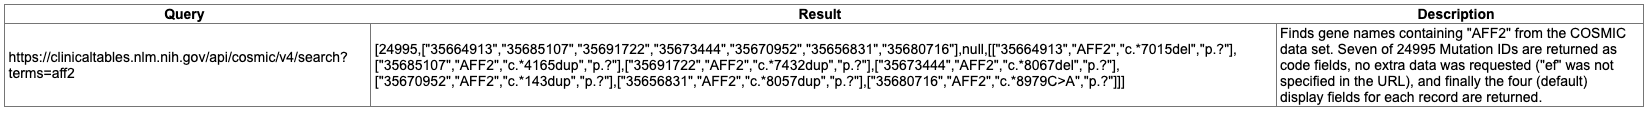

Default spits out MutationID, GeneName, MutationCDS, MutationAA

In [21]:
gene = "KRAS"
mutation = "G12L"

for mut in mut_list:
    c_url = "https://clinicaltables.nlm.nih.gov/api/cosmic/v4/search?terms=" + gene + " OR " + "EZH2" 
    response = requests.get(c_url)
    
    if response:
        print("Results for "+ gene + " " + mut)
        print(response.json())
    
    time.sleep(1)
    

Results for KRAS G12L
[0, [], None, []]
Results for KRAS G12D
[0, [], None, []]
Results for KRAS G13C
[0, [], None, []]
Results for KRAS Q61R
[0, [], None, []]


In [23]:
c_url = "https://clinicaltables.nlm.nih.gov/api/cosmic/v4/search?terms=" + gene + " OR " + "EZH2" 
response = requests.get(c_url)
    
if response:
    print(response.json())

[10000, ['187306870', '187306870', '187306870', '187306870', '187306870', '187306870', '187306870'], None, [['187306870', 'EZH2', 'c.?', 'p.?'], ['187306870', 'EZH2', 'c.?', 'p.?'], ['187306870', 'EZH2', 'c.?', 'p.?'], ['187306870', 'EZH2', 'c.?', 'p.?'], ['187306870', 'EZH2', 'c.?', 'p.?'], ['187306870', 'EZH2', 'c.?', 'p.?'], ['187306870', 'EZH2', 'c.?', 'p.?']]]


In [24]:
gene = "KRAS"
mutation = "G12L"

for mut in mut_list:
    c_url = "https://clinicaltables.nlm.nih.gov/api/cosmic/v4/search?terms=" + gene + " " + mut
    response = requests.get(c_url)
    
    if response:
        print("Results for "+ gene + " " + mut)
        print(response.json())
    
    time.sleep(1)
    

Results for KRAS G12A
[229, ['187306469', '187306469', '187306469', '187306469', '187306469', '187306469', '187306469'], None, [['187306469', 'KRAS', 'c.?', 'p.G12A'], ['187306469', 'KRAS', 'c.?', 'p.G12A'], ['187306469', 'KRAS', 'c.?', 'p.G12A'], ['187306469', 'KRAS', 'c.?', 'p.G12A'], ['187306469', 'KRAS', 'c.?', 'p.G12A'], ['187306469', 'KRAS', 'c.?', 'p.G12A'], ['187306469', 'KRAS', 'c.?', 'p.G12A']]]
Results for KRAS G12C
[745, ['187306469', '187306469', '187306469', '187306469', '187306469', '187306597', '187306597'], None, [['187306469', 'KRAS', 'c.?', 'p.G12A'], ['187306469', 'KRAS', 'c.?', 'p.G12A'], ['187306469', 'KRAS', 'c.?', 'p.G12A'], ['187306469', 'KRAS', 'c.?', 'p.G12A'], ['187306469', 'KRAS', 'c.?', 'p.G12A'], ['187306597', 'KRAS', 'c.?', 'p.G12C'], ['187306597', 'KRAS', 'c.?', 'p.G12C']]]
Results for KRAS G12D
[176, ['187306252', '187306252', '187306252', '187306252', '187306252', '187306252', '187306252'], None, [['187306252', 'KRAS', 'c.?', 'p.G12D'], ['187306252', 

In [19]:
import requests
import time
import json

# Gene and list of mutations
gene = "KRAS"
mut_list = ["G12L", "G12D", "G13C", "Q61R"]  # Replace with your actual list of mutations

# Function to query COSMIC API and process responses
def query_cosmic(gene, mutations, delay=1):
    results = []
    
    for mut in mutations:
        c_url = f"https://clinicaltables.nlm.nih.gov/api/cosmic/v4/search?terms={gene}"
        try:
            response = requests.get(c_url)
            if response.status_code == 200:
                print(f"Results for {gene} {mut}:")
                json_data = response.json()
                results.append({
                    "gene": gene,
                    "mutation": mut,
                    "data": json_data
                })
                print(json.dumps(json_data, indent=2))  # Pretty print the JSON response
            else:
                print(f"Error fetching data for {gene} {mut}: {response.status_code}")
        except Exception as e:
            print(f"Exception occurred while querying {gene} {mut}: {e}")
        
        # Respect the delay to avoid rate limiting
        time.sleep(delay)
    
    return results

# Query COSMIC and collect results
cosmic_results = query_cosmic(gene, mut_list)

# Save results to a JSON file for further analysis
with open("cosmic_results.json", "w") as f:
    json.dump(cosmic_results, f, indent=2)

print("Query complete. Results saved to cosmic_results.json.")


Results for KRAS G12L:
[
  4647,
  [
    "187305524",
    "187305524",
    "187305524",
    "187305524",
    "187305524",
    "187305524",
    "187305524"
  ],
  null,
  [
    [
      "187305524",
      "KRAS",
      "c.?",
      "p.?"
    ],
    [
      "187305524",
      "KRAS",
      "c.?",
      "p.?"
    ],
    [
      "187305524",
      "KRAS",
      "c.?",
      "p.?"
    ],
    [
      "187305524",
      "KRAS",
      "c.?",
      "p.?"
    ],
    [
      "187305524",
      "KRAS",
      "c.?",
      "p.?"
    ],
    [
      "187305524",
      "KRAS",
      "c.?",
      "p.?"
    ],
    [
      "187305524",
      "KRAS",
      "c.?",
      "p.?"
    ]
  ]
]
Results for KRAS G12D:
[
  4647,
  [
    "187305524",
    "187305524",
    "187305524",
    "187305524",
    "187305524",
    "187305524",
    "187305524"
  ],
  null,
  [
    [
      "187305524",
      "KRAS",
      "c.?",
      "p.?"
    ],
    [
      "187305524",
      "KRAS",
      "c.?",
      "p.?"
    ],
    [
      

In [20]:
import requests
import time
import json

# Gene to query
gene = "KRAS"

# Function to query COSMIC API for a gene
def query_cosmic_by_gene(gene, delay=1):
    c_url = f"https://clinicaltables.nlm.nih.gov/api/cosmic/v4/search?terms={gene} "
    results = []

    try:
        response = requests.get(c_url)
        if response.status_code == 200:
            print(f"Results for {gene}:")
            print(response.json())
            json_data = response.json()
            results.append({
                "gene": gene,
                "data": json_data
            })
            print(json.dumps(json_data, indent=2))  # Pretty print the JSON response
        else:
            print(f"Error fetching data for {gene}: {response.status_code}")
    except Exception as e:
        print(f"Exception occurred while querying {gene}: {e}")
    
    # Respect the delay if making multiple queries in a loop
    time.sleep(delay)

    return results

# Query COSMIC and collect results
cosmic_results = query_cosmic_by_gene(gene)

# Save results to a JSON file for further analysis
with open("cosmic_results.json", "w") as f:
    json.dump(cosmic_results, f, indent=2)

print("Query complete. Results saved to cosmic_results.json.")


Results for KRAS:
[4647, ['187305524', '187305524', '187305524', '187305524', '187305524', '187305524', '187305524'], None, [['187305524', 'KRAS', 'c.?', 'p.?'], ['187305524', 'KRAS', 'c.?', 'p.?'], ['187305524', 'KRAS', 'c.?', 'p.?'], ['187305524', 'KRAS', 'c.?', 'p.?'], ['187305524', 'KRAS', 'c.?', 'p.?'], ['187305524', 'KRAS', 'c.?', 'p.?'], ['187305524', 'KRAS', 'c.?', 'p.?']]]
[
  4647,
  [
    "187305524",
    "187305524",
    "187305524",
    "187305524",
    "187305524",
    "187305524",
    "187305524"
  ],
  null,
  [
    [
      "187305524",
      "KRAS",
      "c.?",
      "p.?"
    ],
    [
      "187305524",
      "KRAS",
      "c.?",
      "p.?"
    ],
    [
      "187305524",
      "KRAS",
      "c.?",
      "p.?"
    ],
    [
      "187305524",
      "KRAS",
      "c.?",
      "p.?"
    ],
    [
      "187305524",
      "KRAS",
      "c.?",
      "p.?"
    ],
    [
      "187305524",
      "KRAS",
      "c.?",
      "p.?"
    ],
    [
      "187305524",
      "KRAS",
 

In [25]:
API_URL = 'https://clinicaltables.nlm.nih.gov/api/cosmic/v4/search'

def fetch_mutations(gene_name, max_results=1000):
    params = {
        'terms': gene_name,
        #include ef if you want to protein name
        'maxList': max_results
    }
    response = requests.get(API_URL, params=params)
    response.raise_for_status()  # Raise an error for bad status codes
    return response.json()


fetch_mutations("EZH2")

[10000,
 ['187306870',
  '187306870',
  '187306870',
  '187306870',
  '187306870',
  '187306870',
  '187306870',
  '187306870',
  '187306870',
  '187306870',
  '187306870',
  '187306870',
  '187307891',
  '187320083',
  '27774972',
  '187313637',
  '187319479',
  '187318431',
  '187311129',
  '32817554',
  '187318431',
  '27774972',
  '187314713',
  '187316884',
  '32817554',
  '187316859',
  '187318127',
  '187318531',
  '187308710',
  '187311948',
  '27775645',
  '32822325',
  '32818283',
  '27785186',
  '32817151',
  '27774484',
  '32824375',
  '27782011',
  '27779842',
  '32827799',
  '187318473',
  '187320760',
  '187307359',
  '187307392',
  '187310475',
  '187315129',
  '187308149',
  '187313329',
  '27788153',
  '27790930',
  '27776080',
  '27793706',
  '27795709',
  '27773377',
  '27789751',
  '27788626',
  '27787562',
  '27780964',
  '27780728',
  '27794973',
  '27791762',
  '27774200',
  '27779656',
  '32817793',
  '32836592',
  '32819326',
  '32833015',
  '32818268',
  '328